# Multidimensional Scaling of Perturbations

In [1]:
# imports
import time
import jax
import jax.numpy as jnp
import functools
import numpy as np
import pandas as pd
from ott.core import sinkhorn
from ott.geometry import pointcloud
from sklearn import manifold
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from ml_collections import ConfigDict
from tqdm.notebook import trange, tqdm

# internal imports
from condot.utils.loaders import load_data
from condot.data.utils import cast_loader_to_iterator
from condot.losses.sinkhorn import sinkhorn_loss

/Users/bunnech/miniforge3/envs/cell/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib.colors import LinearSegmentedColormap
plt.rcParams['font.family'] = 'serif'
sns.set_context(context='talk', font_scale=.9)
palette = ['#1A254B', '#114083', '#A7BED3', '#F2545B', '#A4243B']
palette_reduced = ['#1A254B', '#F2545B']

In [3]:
%cd ..

/Users/bunnech/Documents/PhD/Projects/cell_dynamics/condot


## Get Configs and Datasets

In [4]:
config = ConfigDict(yaml.load(open('configs/tasks/norman.yaml'), Loader=yaml.UnsafeLoader))
config.update(yaml.load(open('configs/pca.yaml'), Loader=yaml.UnsafeLoader))
config.update(yaml.load(open('configs/condot.yaml'), Loader=yaml.UnsafeLoader))
config.data.target = 'all'

In [5]:
dataset = load_data(config, return_as='anndata')

In [6]:
loader = load_data(config)
iterator = cast_loader_to_iterator(loader, cycle_all=True)

In [7]:
perturbations = set(dataset.obs.condition)
single_perturbations = [x for x in perturbations if not '+' in x]

## Compute SMACOF Embedding

In [8]:
@jax.jit
def wasserstein_loss(x, y, epsilon=0.1):
    """Computes transport between x and y via Sinkhorn algorithm."""
    a = jnp.ones(len(x)) / len(x)
    b = jnp.ones(len(y)) / len(y)

    # compute cost
    geom_xy = pointcloud.PointCloud(x, y, epsilon=epsilon)

    # solve ot problem
    out_xy = sinkhorn.sinkhorn(geom_xy, a, b, max_iterations=100, min_iterations=10)

    # return regularized ot cost
    return out_xy.reg_ot_cost

In [9]:
def sinkorn_pdist(data, label, epsilon=0.1):
    similarity_matrix = jnp.full(shape=(len(label), len(label)), fill_value=jnp.inf)

    with tqdm(total=len(label) ** 2) as pbar:
        for i, label_i in enumerate(label):
            for j, label_j in enumerate(label):
                x = data[data.obs.condition == label_i].X
                y = data[data.obs.condition == label_j].X
                if similarity_matrix.at[i, j].get() == jnp.inf and similarity_matrix.at[j, i].get() == jnp.inf:
                    w_dist = wasserstein_loss(x, y, epsilon=epsilon)
                    similarity_matrix = similarity_matrix.at[i, j].set(w_dist)
                    similarity_matrix = similarity_matrix.at[j, i].set(w_dist)
                pbar.update(1)
    return similarity_matrix

In [10]:
dissimilarities = sinkorn_pdist(dataset, single_perturbations)

  0%|          | 0/8464 [00:00<?, ?it/s]

In [11]:
pdist_results = pd.DataFrame(data=dissimilarities, index=single_perturbations, columns=single_perturbations)
pdist_results.to_csv(f'results/embedding/pdist_pert_{int(time.time())}.csv')

In [24]:
embedding, stress = manifold.smacof(dissimilarities, metric=True, n_components=10)

In [25]:
embedding_norm = (embedding - embedding.min())/(embedding.max() - embedding.min())

In [26]:
smacof_10d = pd.DataFrame(data=embedding.T, columns=single_perturbations)

In [27]:
smacof_10d.to_hdf('results/perturbation_embedding.h5', key='smacof_10d')

In [28]:
embedding, stress = manifold.smacof(dissimilarities, metric=True, n_components=2)

In [29]:
embedding_norm = (embedding - embedding.min())/(embedding.max() - embedding.min())

In [30]:
smacof_2d = pd.DataFrame(data=embedding.T, columns=single_perturbations)

In [31]:
smacof_2d

,TBX2,COL1A1,ZBTB1,ETS2,MEIS1,SAMD1,TGFBR2,CLDN6,MAPK1,TBX3,...,PRDM1,IER5L,ZC3HAV1,POU3F2,UBASH3A,SET,CDKN1B,CSRNP1,RREB1,AHR
0,31.905321,-23.249132,38.222093,-16.761247,-2.983060,33.197731,7.691236,31.309030,-2.970455,11.260958,...,46.027113,9.328724,6.501883,-5.389416,-6.549055,42.094915,31.772236,8.110476,14.485696,-20.071443
1,-24.430322,-37.718114,-2.147974,-34.000918,11.435342,0.748884,-9.000442,20.703587,-50.743475,-37.817588,...,38.552063,31.123891,-23.858778,25.984400,7.090691,-24.046058,-5.239057,-15.507027,25.757658,25.398531


In [32]:
smacof_2d.to_hdf('results/perturbation_embedding.h5', key='smacof_2d')

## Visualize SMACOF Embedding

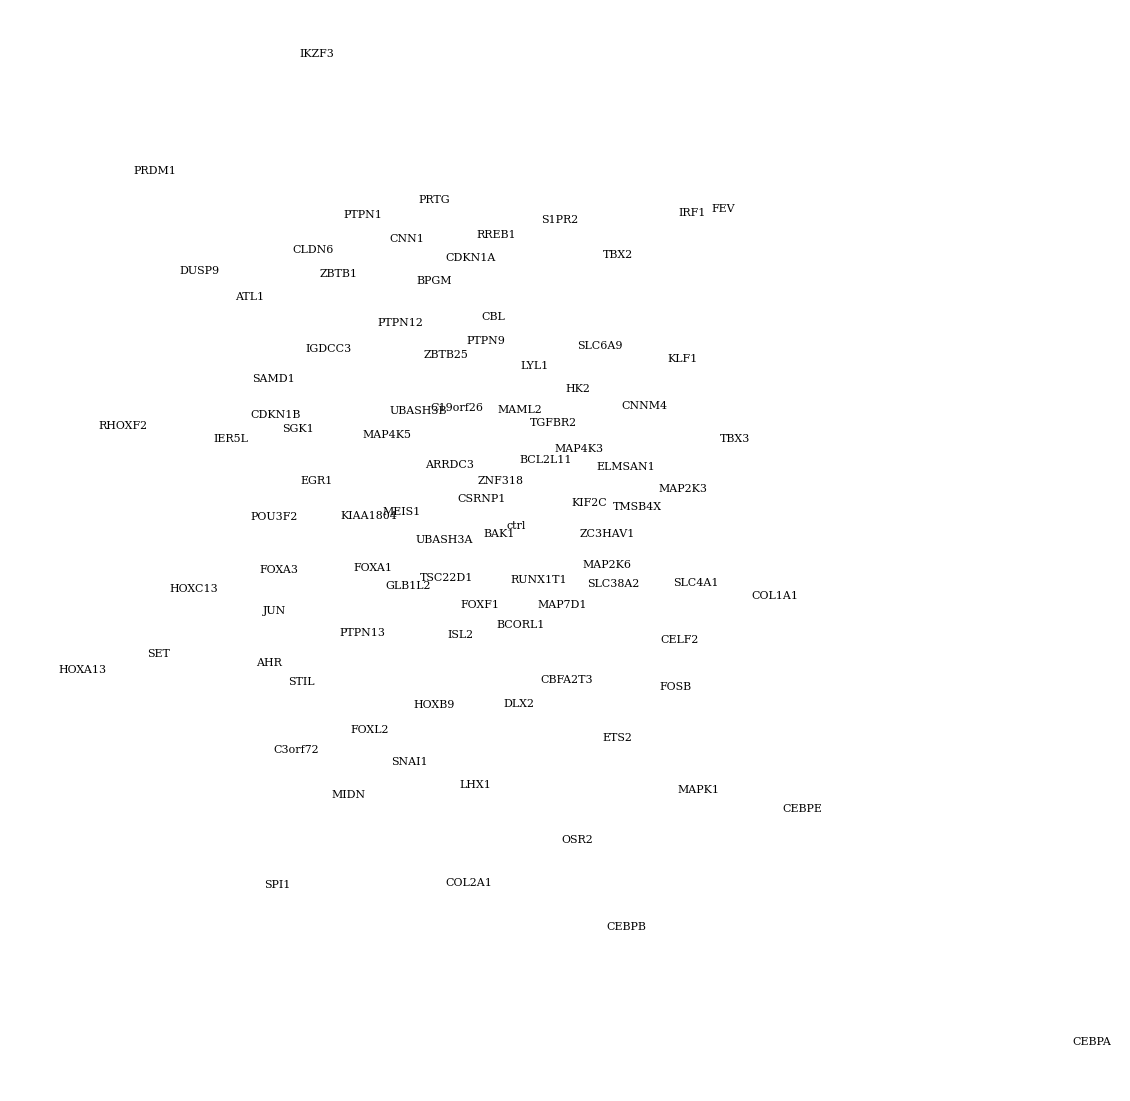

In [23]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(embedding[:, 0], embedding[:, 1], c='w', s=10)

for i, label in enumerate(single_perturbations):
    ax.annotate(label, (embedding[i, 0], embedding[i, 1]), fontsize=11)
plt.axis('off')
fig.savefig('notebooks/figures/fig_smacof_perturb.pdf', bbox_inces='tight')

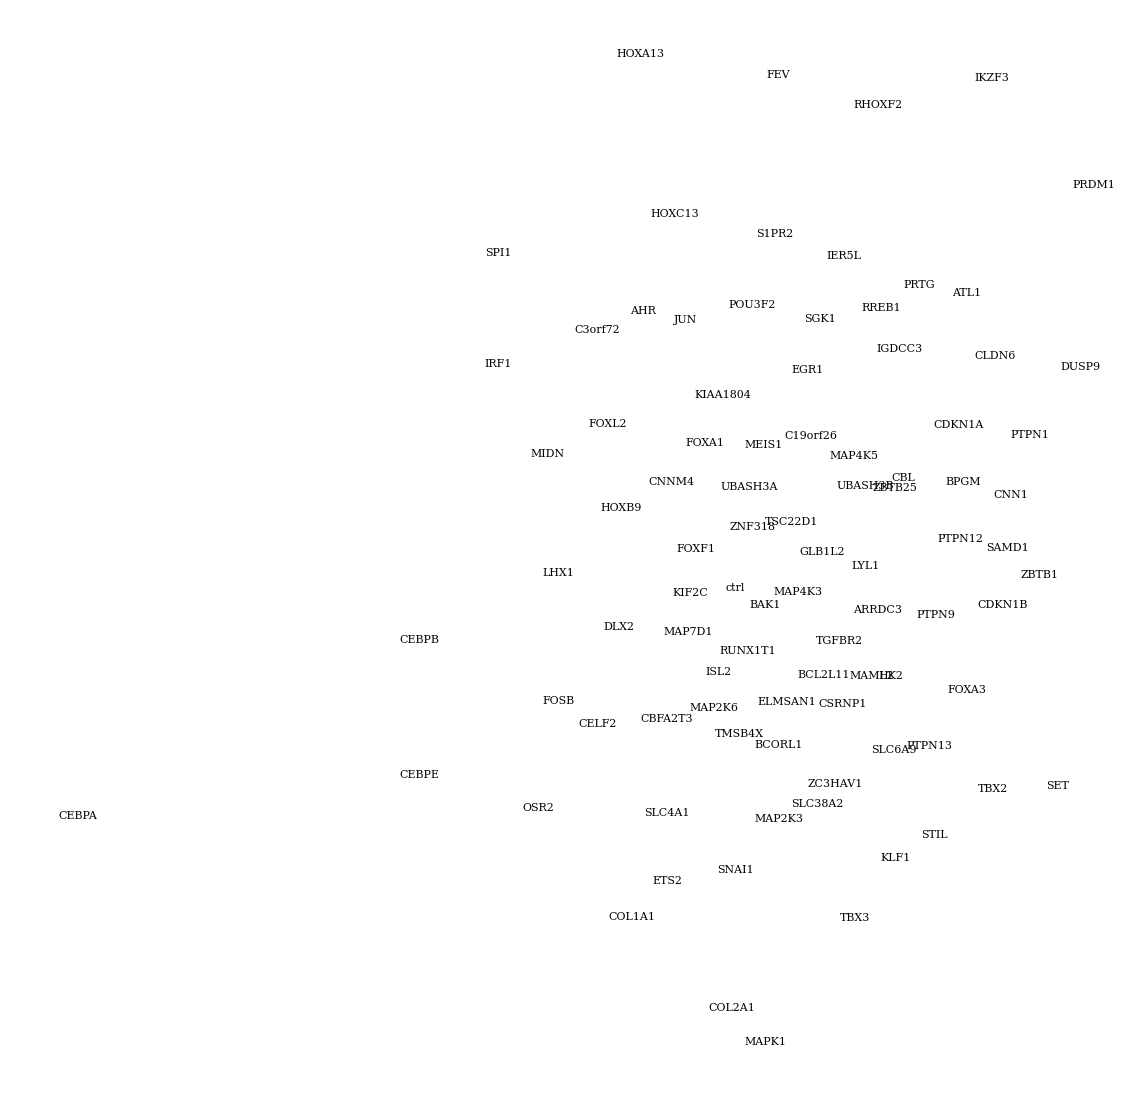

In [33]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(embedding_norm[:, 0], embedding_norm[:, 1], c='w', s=10)

for i, label in enumerate(single_perturbations):
    ax.annotate(label, (embedding_norm[i, 0], embedding_norm[i, 1]), fontsize=11)
plt.axis('off')
fig.savefig('notebooks/figures/fig_smacof_perturb.pdf', bbox_inces='tight')